In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from spec_id import Gen_spec,Scale_model, Median_w_Error_95
import pandas as pd
from spec_id import Median_w_Error_cont
from glob import glob
import grizli.model
from astropy.io import fits, ascii
from astropy.table import Table
import os
from shutil import copy
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
def Best_fit_model(input_file, metal, age, redshift):
    chi = np.load(input_file)
    x = np.argwhere(chi == np.min(chi))
    print(metal[x[0][0]], age[x[0][1]], redshift[x[0][2]])
    return metal[x[0][0]], age[x[0][1]], redshift[x[0][2]]

In [3]:
def Analyze_LH_specz(chifits, metal, age, rshift):
    ####### Read in file
    chi = np.load(chifits)

    P = np.exp(-chi.astype(np.float128) / 2)

    Pz = np.trapz(np.trapz(P.T, metal, axis=2), age, axis=1) /\
        np.trapz(np.trapz(np.trapz(P.T, metal, axis=2), age, axis=1),rshift)
    
    return Pz

In [4]:
metal=np.round(np.array([0.002, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]),3)
age=np.round(np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]),2)

z=np.round(np.arange(0.8,2.001,0.001),3)

In [5]:
flist = glob('../spec_stacks//*.npy')
glist = [os.path.basename(U).replace('.npy','') for U in flist]

In [6]:
glist

['n16758',
 'n17070',
 'n21156',
 'n21427',
 'n23435',
 'n23758',
 'n32566',
 'n34694',
 'n37686',
 'n37955',
 's19148',
 's35774',
 's38785',
 's39012',
 's39170',
 's39241',
 's39631',
 's39804',
 's39805',
 's39850',
 's40223',
 's40476',
 's40597',
 's40623',
 's40862',
 's41520',
 's42221',
 's43615',
 's44042',
 's44620',
 's45972',
 's46066',
 's47677']

In [92]:
len(meds)

66

In [13]:
# ngalDB = pd.DataFrame({'gids':glist,'z_grism':meds,'z_grism_-':mlers,'z_grism_+':mhers})
ngalDB = ngalDB.query('1.0<= z_grism <=1.82')

In [7]:
def Median_w_Error_95(Pofx, x):
    iP = interp1d(x, Pofx)
    ix = np.linspace(x[0], x[-1], 5000)

    lerr = 0
    herr = 0

    for i in range(len(ix)):
        e = np.trapz(iP(ix[0:i + 1]), ix[0:i + 1])
        if lerr == 0:
            if e >= .025:
                lerr = ix[i]
        if herr == 0:
            if e >= .975:
                herr = ix[i]
                break

    med = 0

    for i in range(len(x)):
        e = np.trapz(Pofx[0:i + 1], x[0:i + 1])
        if med == 0:
            if e >= .5:
                med = x[i]
                break

    return np.round(med,3), np.round(med - lerr,3), np.round(herr - med,3)

In [8]:
meds,mlers,mhers = [[],[],[]]
for i in range(len(glist)):
    z,Pz = np.load('../rshift_dat/{0}_zfit_Pz.npy'.format(glist[i]))
    med,mler,mher = Median_w_Error_95(Pz,z)
#     meds.append(med)
#     mlers.append(mler)
#     mhers.append(mher)
#     bfm,bfa,bfz = Best_fit_model('../rshift_dat/{0}_zfit_chidata.npy'.format(glist[i]),metal,age,z)
    bfz = z[Pz==max(Pz)]
    if mler == 0.0:
        mler = 0.001
    if mher == 0.0:
        mher = 0.001
        
    meds.append(bfz[0])
    mlers.append(mler)
    mhers.append(mher)    
#     print( mler+mher)
#     plt.figure(figsize=[8,8])
#     plt.plot(z,Pz)
#     plt.axvline(med)
#     plt.axvline(bfz,color='r')
# #     plt.axvline(med - mler,color='r')
# #     plt.axvline(med + mher,color='r')
# #     plt.xlim(med - 0.02,med + 0.02)
#     plt.title(glist[i])


In [27]:
ngalDB = ngalDB.reset_index(drop=True)

In [28]:
ngalDB.to_pickle('../data/upd_galDB.pkl')

In [10]:
class Gen_spec(object):
    def __init__(self, galaxy_id, redshift,minwv = 7900, maxwv = 11300, shift = 1):
        self.galaxy_id = galaxy_id
        self.gid = int(self.galaxy_id[1:])
        self.redshift = redshift
        self.shift = shift

        """ 
        self.flt_input - grism flt (not image flt) which contains the object you're interested in modeling, this
                         will tell Grizli the PA
        **
        self.galaxy_id - used to id galaxy and import spectra
        **
        self.beam - information used to make models
        **
        self.wv - output wavelength array of simulated spectra
        **
        self.fl - output flux array of simulated spectra
        """

        gal_wv, gal_fl, gal_er = np.load(glob('../spec_stacks/*{0}*'.format(self.gid))[0])
        self.flt_input = glob('../beams/*{0}*'.format(self.gid))[0]

        IDX = [U for U in range(len(gal_wv)) if minwv <= gal_wv[U] <= maxwv]
        
        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0 ]
        self.gal_wv = self.gal_wv[self.gal_fl > 0 ]
        self.gal_er = self.gal_er[self.gal_fl > 0 ]
        self.gal_fl = self.gal_fl[self.gal_fl > 0 ]
        

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(fits_file=self.flt_input)

        ## Get sensitivity function

        flat = self.beam.flat_flam.reshape(self.beam.beam.sh_beam)
        fwv, ffl, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,
                        flat.shape[0]]),flat.T[:-1*self.shift],axis=0).T , bin=0)
        
        self.filt = interp1d(fwv, ffl)(self.gal_wv)
        
    def Sim_spec(self, metal, age, tau, model_redshift = 0):
        if model_redshift ==0:
            model_redshift = self.redshift
        
        model = '../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal, age, tau)

        wave, fl = np.load(model)

        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift),fl])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1*self.shift],axis=0).T , bin=0)

        ifl = interp1d(w, f)(self.gal_wv)
        adj_ifl = ifl /self.filt
        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.fl = C * adj_ifl
        
    def Sim_spec_mult(self, wave, fl, model_redshift = 0):
        if model_redshift ==0:
            model_redshift = self.redshift

        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift), fl])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1]*self.shift,axis=0).T , bin=0)

        self.fl = f
        self.mwv = w

0.025 3.5 1.0149999999999999023


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

0.01 2.0 1.1990000000000000657


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


0.02 2.0 1.2529999999999998916
0.03 1.0 1.5760000000000000675
0.005 3.5 1.1390000000000000124
0.002 4.0 1.161000000000000032
0.025 1.5 1.1510000000000000231
0.02 2.5 1.1510000000000000231
0.015 3.5 1.2569999999999998952
0.03 3.0 1.026999999999999913
0.03 1.5 1.2290000000000000924
0.03 1.5 1.1799999999999999378
0.01 4.5 1.6109999999999999876
0.03 2.5 1.0229999999999999094
0.025 4.0 1.0169999999999999041
0.015 4.5 1.0569999999999999396
0.015 4.5 1.3329999999999999627
0.025 1.5 1.2419999999999999929
0.015 2.0 1.5929999999999999716
0.015 2.0 1.2090000000000000746
0.03 1.5 1.2179999999999999716


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.02 3.5 1.4179999999999999272
0.03 2.5 1.3280000000000000693
0.03 1.5 1.6049999999999999822
0.005 1.5 1.0189999999999999059
0.03 4.5 1.0200000000000000178
0.005 4.0 1.6120000000000000995
0.03 1.0 1.3429999999999999716
0.015 3.0 1.0369999999999999218
0.02 4.5 1.3260000000000000675
0.025 3.0 1.1169999999999999929


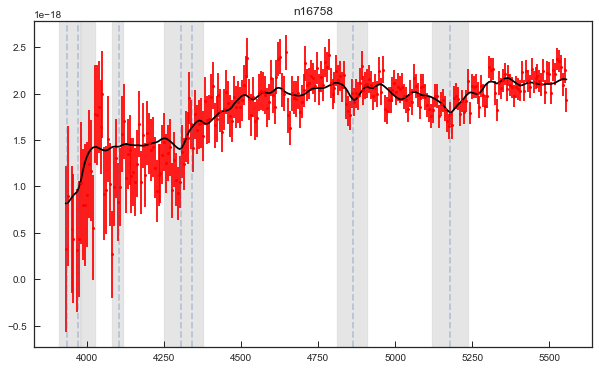

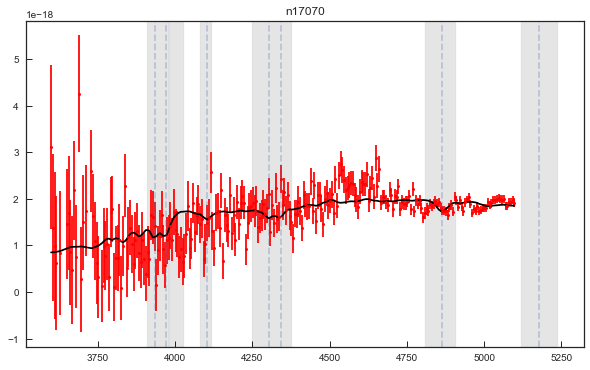

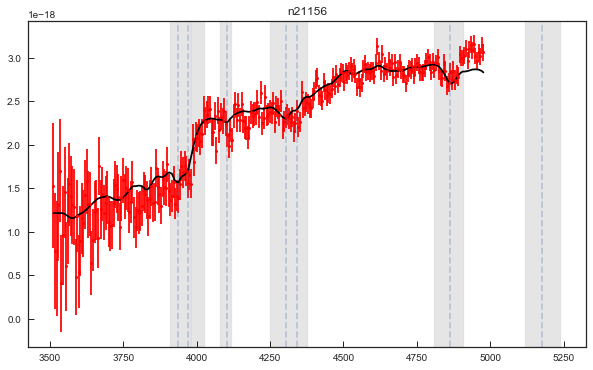

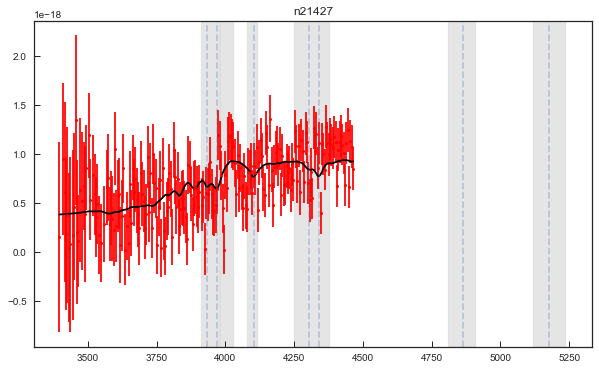

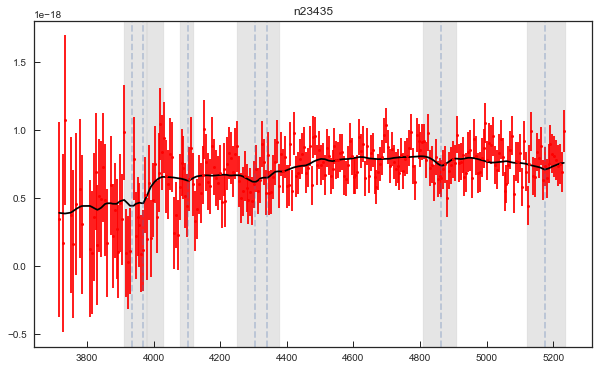

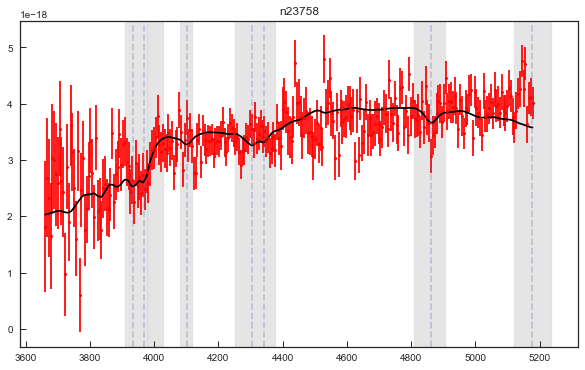

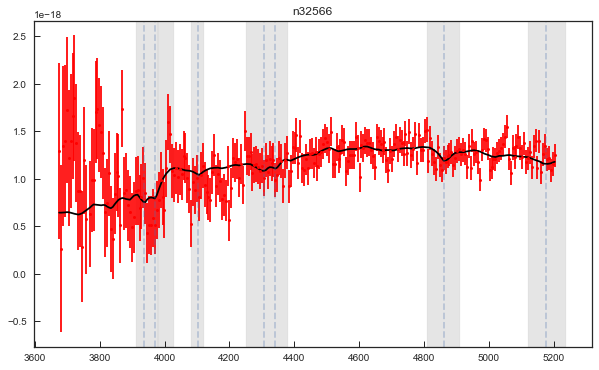

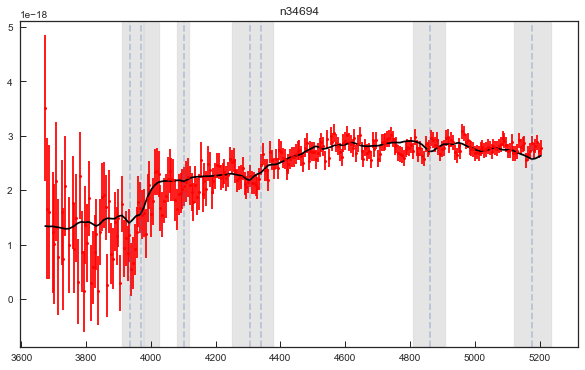

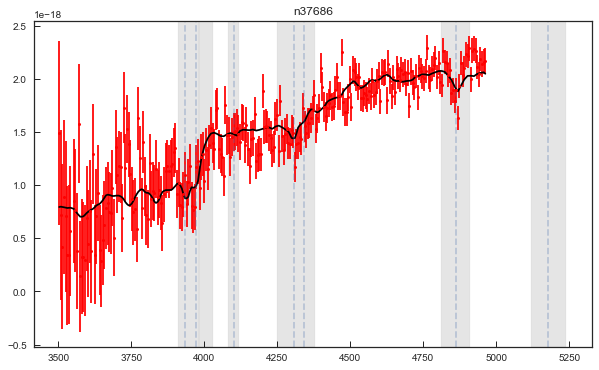

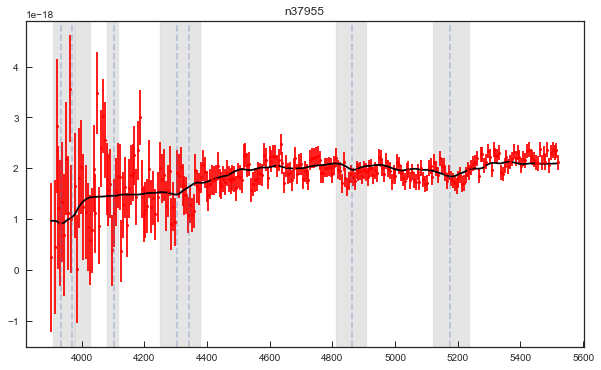

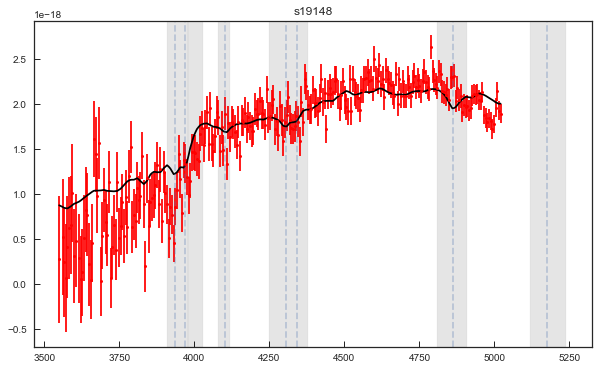

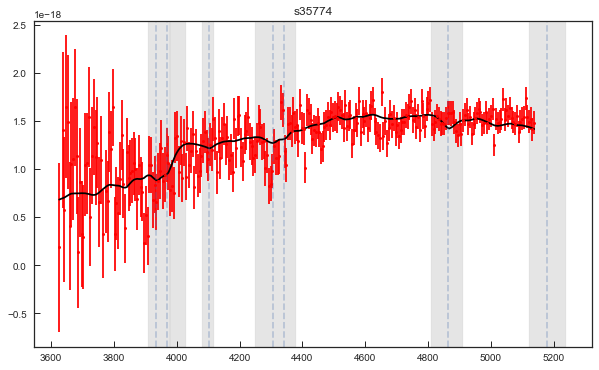

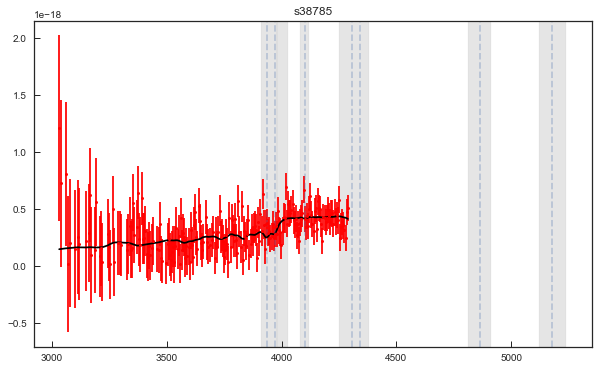

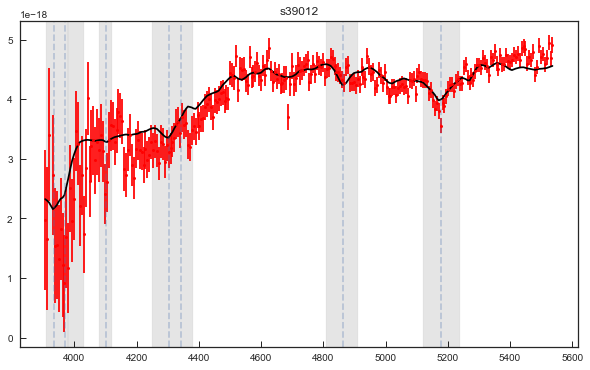

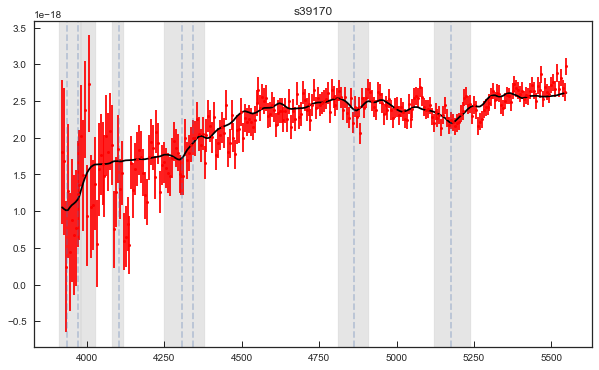

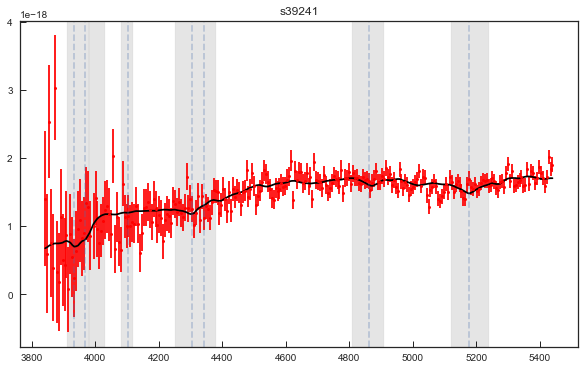

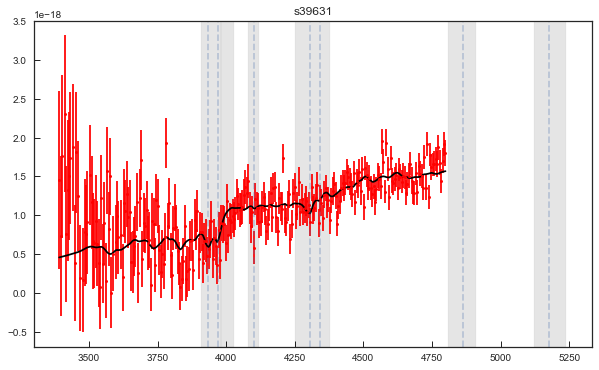

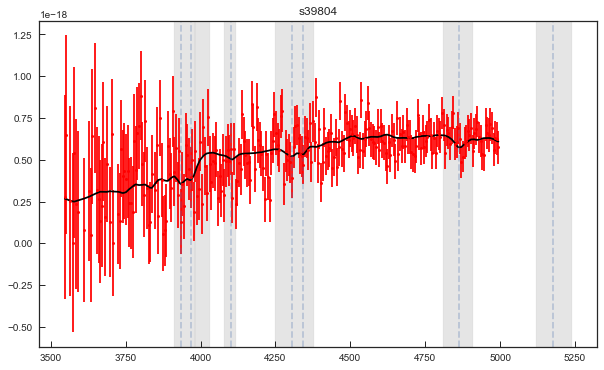

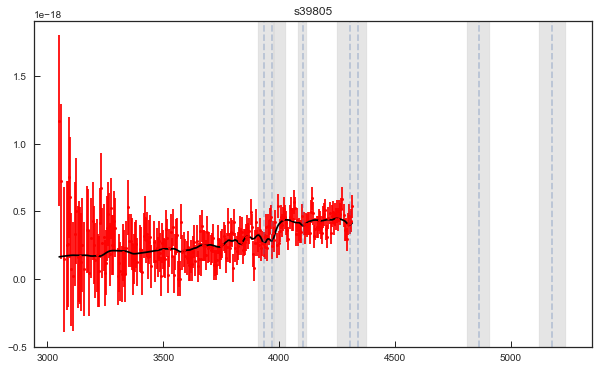

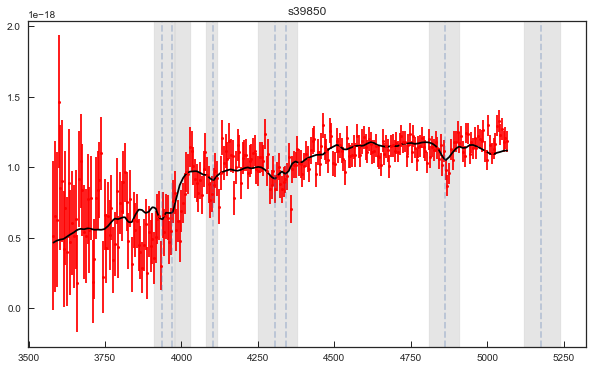

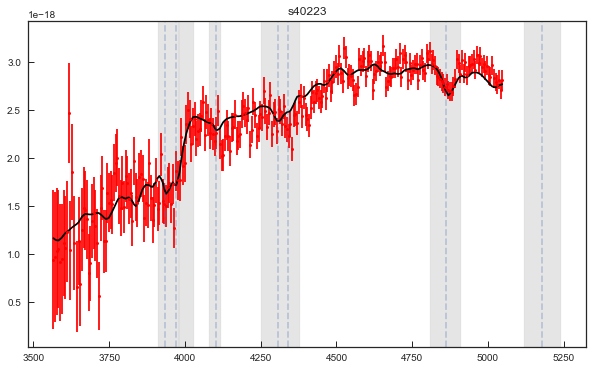

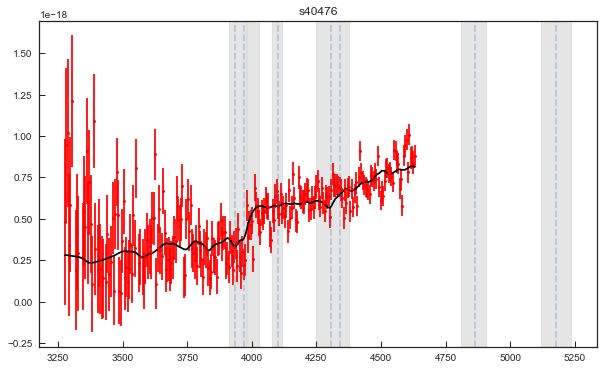

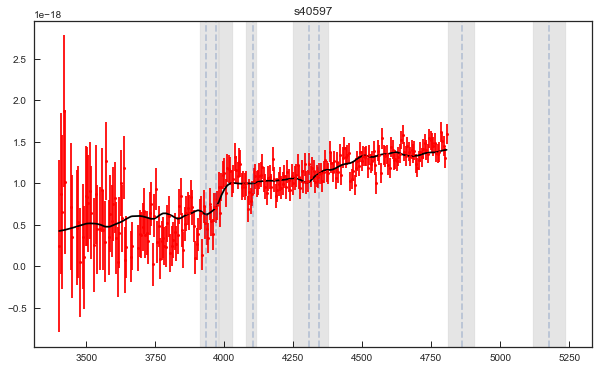

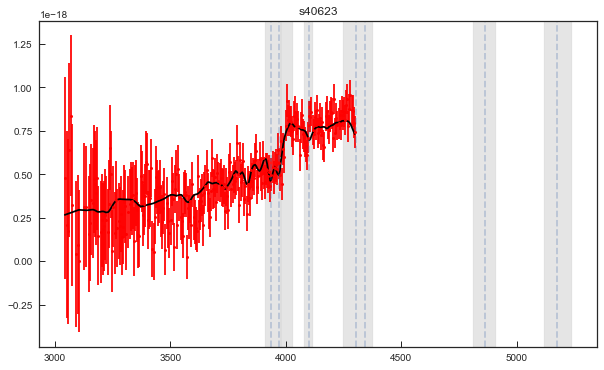

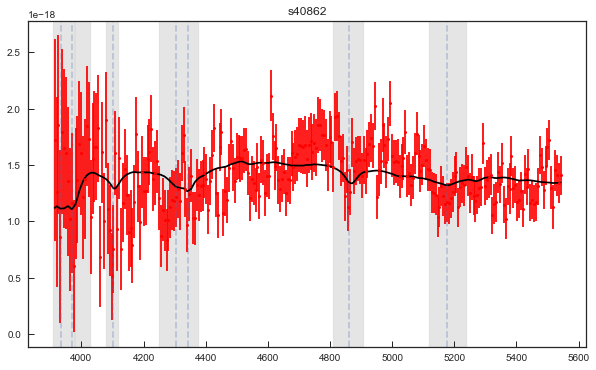

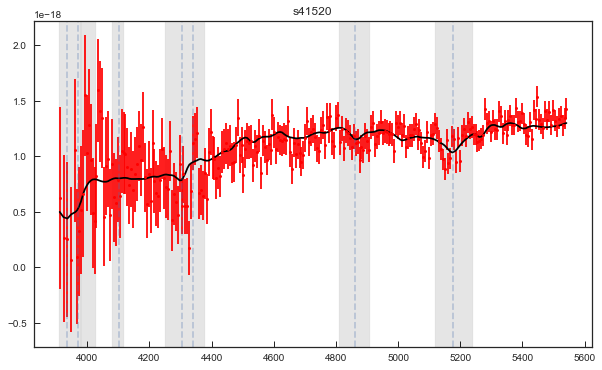

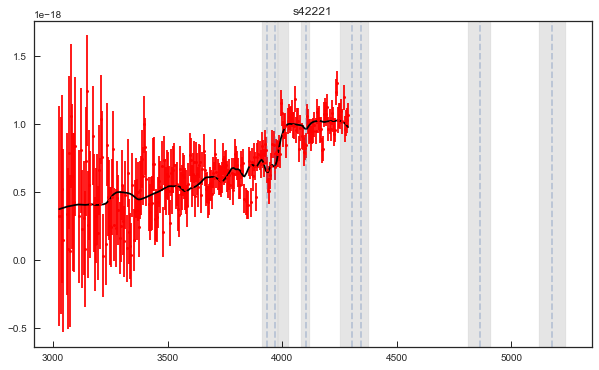

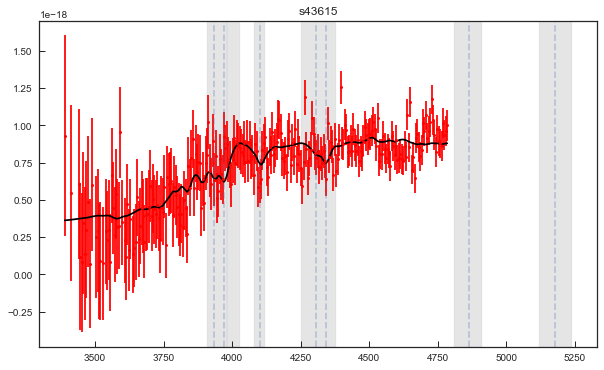

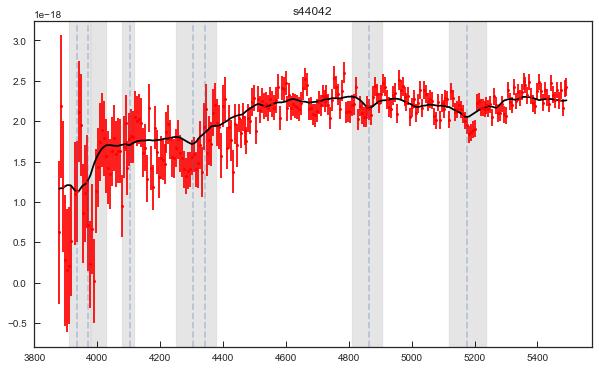

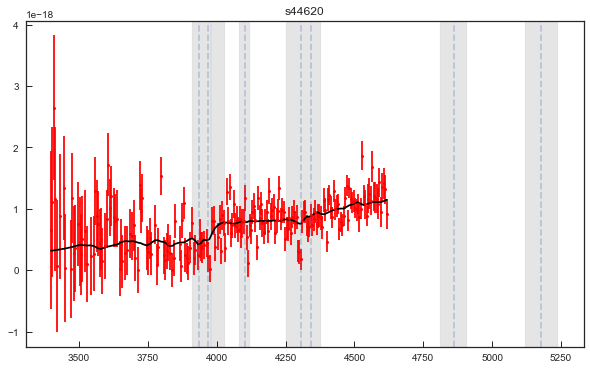

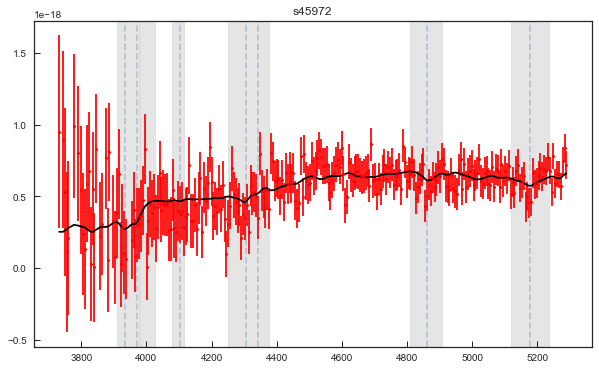

In [30]:
for i in ngalDB.index:
#     z,Pz = np.load('../rshift_dat/{0}_zfit_Pz.npy'.format(glist[i]))
#     med,mler,mher = Median_w_Error_cont(Pz,z)
    bfm,bfa,bfz = Best_fit_model('../rshift_dat/{0}_zfit_chidata.npy'.format(ngalDB.gids[i]),metal,age,z)

    sp = Gen_spec(ngalDB.gids[i],ngalDB.z_grism[i],maxwv=11200)
    sp.Sim_spec(bfm,bfa,8.0)

    plt.figure(figsize=[10,6])
    plt.errorbar(sp.gal_wv_rf,sp.gal_fl, sp.gal_er,linestyle='None', marker='o', markersize=3, color='r')
    plt.plot(sp.gal_wv_rf,sp.fl,'k')
#     sp.Sim_spec(bfm,bfa,8.0,med)
#     plt.plot(sp.gal_wv_rf,sp.fl,'b')
    plt.axvline(3934.777,linestyle='--', alpha=.3)
    plt.axvline(3969.588,linestyle='--', alpha=.3)
    plt.axvline(4102.89,linestyle='--', alpha=.3)
    plt.axvline(4305.61,linestyle='--', alpha=.3)
    plt.axvline(4341.68,linestyle='--', alpha=.3)
    plt.axvline(4862.68,linestyle='--', alpha=.3)
    plt.axvline(5176.7,linestyle='--', alpha=.3)
    plt.axvspan(3910, 3980, color='k', alpha=.1)
    plt.axvspan(3980, 4030, color='k', alpha=.1)
    plt.axvspan(4080, 4120, color='k', alpha=.1)
    plt.axvspan(4250, 4380, color='k', alpha=.1)
    plt.axvspan(4810, 4910, color='k', alpha=.1)
    plt.axvspan(5120, 5240, color='k', alpha=.1)
    plt.title(glist[i])

In [63]:
glist[-20]

's39805'